# Word Embedding With Imdb Dataset

In sentiment analysis, we were only looking for the existence of words in a sentence. However, we can fool sentiment analysis easily when we use synonyms of words. In this case, it may not be able to catch the connection between such a group of words 'good', 'nice', 'great' or 'excellent' while Embedding layers does. Word embedding is the most common way to give words a meaning via setting them weights. Hence, setting similar weights for the synonyms of words (1) and opposite weights to the acronyms (-1) helps the model to distinguish them.

<img src="images/WordEmbeddings.jpg" width=600 height=600>

In [1]:
from keras.layers import Embedding, Flatten, Dense
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import os

Tokenizer in Keras helps us to get the index of each vocabulary in our dataset. Based on that, we can easily replace words with index-based representations of them. Besides, we can set a limit for the number of words in order to deal with only the most commonly used words.

In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [3]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

Embedding layers only work with sentences, which consist of the same amount of words. For this reason, we are using the `pad_sequences` function from `keras.preprocessing` to pad the rest of the sentences with 0s if they have a fewer amount of words. Then, we are going to truncate the sentences that have more words than the specified limit.

In [4]:
preprocessing.sequence.pad_sequences(sequences, maxlen=10)

array([[0, 0, 0, 0, 1, 2, 3, 4, 1, 5],
       [0, 0, 0, 0, 0, 1, 6, 7, 8, 9]], dtype=int32)

In [5]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

The Embedding layer takes at least two arguments:

* The number of possible tokens (max word index + 1 or length of the words)
* Dimension of the dense embedding.

In [6]:
embedding_layer = Embedding(1000, 64)

* `max_features` -> Number of words to consider as features
* `maxlen` -> Cut texts after this number of words
* `pad_sequences` -> Turns our list of integers into a 2D integer tensor of shape `(samples, maxlen)`

In [7]:
max_features = 10000
maxlen = 20

# Loading data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


In [9]:
x_train

array([[  65,   16,   38, ...,   19,  178,   32],
       [  23,    4, 1690, ...,   16,  145,   95],
       [1352,   13,  191, ...,    7,  129,  113],
       ...,
       [  11, 1818, 7561, ...,    4, 3586,    2],
       [  92,  401,  728, ...,   12,    9,   23],
       [ 764,   40,    4, ...,  204,  131,    9]], dtype=int32)

### Building Model

* We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
* Output of the Embedding layers is `(samples, maxlen, embedding_dimension)` which embedding dimension is 8 in this case.
* Then, 3D tensor of embeddings is flattened into a 2D tensor of shape `(samples, maxlen * 8)`

In [10]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6712 - acc: 0.6205 - val_loss: 0.6245 - val_acc: 0.6950
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5469 - acc: 0.7516 - val_loss: 0.5301 - val_acc: 0.7282
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4626 - acc: 0.7886 - val_loss: 0.5019 - va

# Building an Embedding Model From Scratch

* In this case, we will load the raw `IMDb` data-set and process it from scratch until evaluating test data.
* We are going to use pre-trained `GloVe` embedding weights.

### Extracting Raw Texts From Class Folders:


In [11]:
imdb_dir = '/content/drive/My Drive/Colab Notebooks/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_name, fname), 'r') as f:
                texts.append(f.read())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)

### Observing the First 2 Samples:

In [1]:
texts[:2]

['You may say to yourself, "Don Johnson as Elvis? Can that work? Is it possible? Seems like an terrible choice to me, but perhaps I should have an open mind. Maybe I\'ll be surprised. Maybe he can pull it off."<br /><br />NOT!<br /><br />Don Johnson is not a bad actor. But he is an awful Elvis. He\'s too short, too weak-voiced, too sharply featured ... well you\'ve already imagined how bad he would be. Add to that a hokey black wig and heavy-handed eye-liner and mascara and it\'s a big fat embarrassing mess.<br /><br />The best I can say is that since Johnson\'s acting is decent and since his impersonation is so far off, after a while you don\'t even think of him as Elvis anymore. You see him as some other crazed pop star instead. Then, on that level, the movie becomes watchable.<br /><br />Stephanie Zimbalist is also not ideally cast as the tall, beauty queen, Linda Thompson. But she is attractive in her own right and plays the part with the honesty, elegance and intelligence we\'ve c

To demonstrate the power of the `GloVe` embedding word matrix, we will train our model only 200 training and 5000 validation samples, then evaluate our final model with 5000 test samples.

In [13]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 5000  # We will be validating on 5000 samples
test_samples = 5000 # We will be testing on 5000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training and a validation set
# But first, shuffle the data, since we started from organized data, where
# sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[5200:10200]
y_test = labels[5200:10200]

Found 50605 unique tokens.
Shape of data tensor: (8089, 100)
Shape of label tensor: (8089,)


### Installing Glove Embedding Weights

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-08 06:56:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-08 06:56:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-08 06:56:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


We are going to use 100-dimensional `Glove` embedding weights, so before loading it, see the weights of `the` and `,` (comma).

In [2]:
with open('glove.6B.100d.txt', 'r') as f:
  for idx, line in enumerate(f):
    values = line.split()
    print(values)
    if idx+1 == 2:
      break

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

### Glove Matrix Pre-processing

Firstly, we should convert lists to a dictionary, which keys will be the words and values will be the weights of them in order to get their weights efficiently. (Utilizing from the power of hashing)

In [15]:
embeddings_index = {}
with open('glove.6B.100d.txt', 'r') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


As shown above, we have well defined 400000 unique English words within the `Glove` word embedding.

 ### Placing Word Weights in Embedding Matrix

 Previously, we have created a matrix with 10000 parameters for the `IMDb` dataset with the `Tokenizer` class. Now, we will create an embedding matrix to set word weights to our created model.

In [16]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix.shape

(10000, 100)

### Creating Model

We have constructed the embedding matrix, it is time to creating a model and evaluate our data-set.

In [18]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Setting The Embedding Layer's Weights and Freeze Them to Protect `GloVe` Embedding From Training

In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

After freezing the Embedding Layer, we have only 320,065 trainable parameters.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 0s 63ms/step - loss: 0.0960 - acc: 0.9500 - val_loss: 1.0149e-04 - val_acc: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 50ms/step - loss: 6.0193e-06 - acc: 1.0000 - val_loss: 1.0021e-04 - val_acc: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 54ms/step - loss: 5.2581e-06 - acc: 1.0000 - val_loss: 9.9416e-05 - val_acc: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 44ms/step - loss: 4.8939e-06 - acc: 1.0000 - val_loss: 9.8133e-05 - val_acc: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 43ms/step - loss: 4.3829e-06 - acc: 1.0000 - val_loss: 9.6806e-05 - val_acc: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 44ms/step - loss: 3.8912e-06 - acc: 1.0000 - val_loss: 9.2584e-05 - val_acc: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 2.7243e-06 - acc: 1.0000 - val_loss: 9.1122e-05 - val_acc: 1.0000
Epoch 8/10
7/7 [=============================

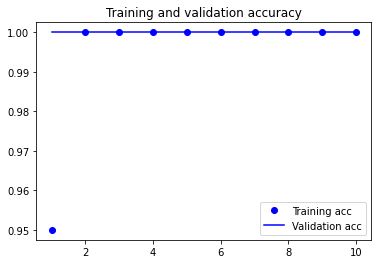

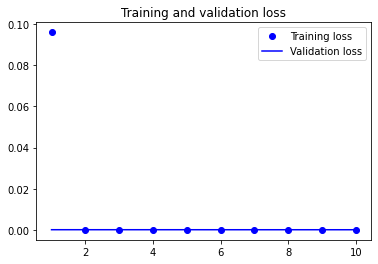

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to GloVe Embedding Weights, we got a 100% accuracy score in the IMDb dataset using only a single layer with 32 units.

In [23]:
model.evaluate(x_test, y_test)

91/91 [==============================] - 0s 2ms/step - loss: 7.8556e-06 - acc: 1.0000


[7.855590411054436e-06, 1.0]

In conclusion, in this notebook, we have covered Embedding Layers and the power of using pre-trained word embeddings with a simple example.